# Домашнее задание 2

_Михаил Воронов_

## Код, примерно скопированный из задания

In [1]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-11-14 13:51:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Распознаётся dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)… 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Подключение к dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 681808098 (650M) [application/zip]
Сохранение в: «wiki-news-300d-1M.vec.zip.1»

ki-news-300d-1M.vec   3%[                    ]  19,94M  6,79MB/s               ^C


In [2]:
# !wget "https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week 3/data.py"

--2020-11-14 13:52:26--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.36.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 10563 (10K) [text/plain]
Сохранение в: «data.py»

data.py             100%[===================>]  10,32K  --.-KB/s    за 0s      

2020-11-14 13:52:26 (62,7 MB/s) - «data.py» сохранён [10563/10563]



Для прошлого задания нужна была специальная версия торча, так как я не создавал окружения,
теперь надо вернуть нормальную для моей куды.

In [47]:
#!pip3 install --user torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
    100% |████████████████████████████████| 735.3MB 26kB/s s eta 0:00:01    16% |█████▍                          | 124.5MB 104.8MB/s eta 0:00:06�█                         | 161.2MB 143.1MB/s eta 0:00:05��████████▌                    | 263.9MB 56.8MB/s eta 0:00:09    56% |██████████████████              | 414.0MB 27.0MB/s eta 0:00:12    60% |███████████████████▍            | 446.0MB 55.1MB/s eta 0:00:06██████            | 461.2MB 83.2MB/s eta 0:00:04��████████████████▏        | 533.5MB 48.9MB/s eta 0:00:05MB/s eta 0:00:02
    100% |████████████████████████████████| 12.7MB 2.2MB/s  eta 0:00:01
    100% |████████████████████████████████| 7.6MB 2.2MB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/60/7a/e881b5abb54db0e6e671ab088d079c57ce54e8a01a3ca443f561ccadb37e/typing_extensions-3.7.4.3-py3-none-any.whl
  Found existing installation: torch 1.6.0+cpu
    Uninstalling torch-1.6.0+cpu:
      Successful

In [1]:
import math
import numpy as np

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

import zipfile

import seaborn as sns

from data import Downloader, Parser

In [2]:
# путь к данным
data_path = './data/'

In [3]:
downloader = Downloader(data_path=data_path)

In [4]:
# downloader.run()

In [5]:
parser = Parser(data_path=data_path)

In [6]:
unlabeled, train, valid = parser.run()

Reading: 100%|██████████| 38/38 [01:50<00:00,  2.92s/it]


In [7]:
set(train.category.unique().tolist()) == set(valid.category.unique().tolist())

True

In [8]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())
category2index = {category: index for index, category in enumerate(unique_categories)}

In [9]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [10]:
# подготовим данные
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

In [11]:
import zipfile
import numpy as np

from tqdm import tqdm

In [12]:
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
            max_words = vocab_size if max_words <= 0 else max_words
            
            # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [13]:
vocab, embeddings = load_embeddings(
    './wiki-news-300d-1M.vec.zip',
    'wiki-news-300d-1M.vec',
    max_words=100_000)

100%|█████████▉| 99999/100000 [00:09<00:00, 11011.28it/s]


In [14]:
index2token = {index: token for token, index in vocab.items()}
emb_norms = np.linalg.norm(embeddings, axis=1)

In [15]:
def get_k_nearest_neighbors(word, embeddings, emb_norms, vocab, index2token, k=5):
    
    if word not in vocab:
        print('Not in vocab')
        return
    
    word_index = vocab[word]

    word_vector = embeddings[word_index]
    word_vector = np.expand_dims(word_vector, 0)

    scores = (word_vector @ embeddings.T)[0]
    
    # переводим в косинусы, поделив на нормы векторов
    # эпсилон 1e-6 для того, чтобы не делить на 0
    scores = scores / (emb_norms + 1e-6) / emb_norms[word_index]
    
    # 1:k+1 потому что первый вариант это само слово
    for idx in scores.argsort()[::-1][1:k+1]:
        print(f'Слово {index2token[idx]} близко на {scores[idx]:.2f} к слову {word}')

In [16]:
get_k_nearest_neighbors('anna', embeddings, emb_norms, vocab, index2token)

Слово maria близко на 0.73 к слову anna
Слово emma близко на 0.66 к слову anna
Слово kristina близко на 0.65 к слову anna
Слово laura близко на 0.65 к слову anna
Слово emily близко на 0.65 к слову anna


In [17]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize

In [18]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def padding(self, tokenized_text):
        
        tokenized_text = tokenized_text[:self.max_length]
        
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        
        return tokenized_text
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target


In [19]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)

In [20]:
x, y = train_dataset[0]

In [21]:
[index2token[idx.item()] for idx in x][:20]

['any',
 'reason',
 'why',
 'this',
 'won',
 "'",
 't',
 '(',
 'lift',
 ')',
 'gas',
 'out',
 'of',
 'one',
 'tank',
 'to',
 'another',
 'tank',
 '?',
 'PAD']

In [22]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)

## Задание

In [102]:
import numpy as np
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm

In [24]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# Обучаю на видюхе
DEVICE

device(type='cuda')

In [151]:
class LstmModel(torch.nn.Module):
    def __init__(
            self,
            emdeddings,
            nclasses: int,
            lstm_size: int,
            bidirectional: bool,
            num_layers: int):
        super().__init__()
        self._embeddings_layer = torch.nn.Embedding.from_pretrained(
            torch.tensor(embeddings).float().to(DEVICE), padding_idx=0)
        self._embeddings_dim = embeddings.shape[-1]
        
        self._dropout = torch.nn.Dropout(p=0.4)
        self._lstm = torch.nn.LSTM(
            self._embeddings_dim,
            lstm_size,
            batch_first=True,
            bidirectional=bidirectional,
            num_layers=num_layers
        )
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self._lstm_size = lstm_size
        lstm_output_dim = lstm_size if not bidirectional else 2 * lstm_size
        self._classification_layer = torch.nn.Linear(lstm_output_dim, nclasses)
        
    
    def forward(self, x):
        x = self._embeddings_layer(x)
        x = self._dropout(x)
        output, (hidden, _) = self._lstm(x)
        x = F.layer_norm(x, x.shape)
        # в доках написано, что так надо отделять hidden слой
        hidden = hidden.view(self.num_layers, 2 if self.bidirectional else 1, -1, self._lstm_size)
        # берём последний слой
        hidden = hidden[-1]
        # делаем батч-фёрст
        hidden = hidden.transpose(0, 1)
        # получаем батч-сайз и размер lstm с поправкой на двунаправленность
        # без `contiguous` не работает
        hidden = hidden.contiguous().view(hidden.size(0), -1)
        return self._classification_layer(hidden)

In [74]:
criterion = torch.nn.CrossEntropyLoss()

In [75]:
import warnings
warnings.filterwarnings('ignore')

В есть специальный класс для ноутбуков, обычный багует.
В старых версиях `tqdm` этого нет, поэтому, если не сработает, надо сделать:
```
pip install -U tqdm
```

In [140]:
from tqdm.notebook import tqdm

Epoch 1 of 10, train:   8%|▊         | 155/1954 [00:22<01:24, 21.23it/s, train_loss=1.6]

In [178]:
from collections import defaultdict, namedtuple
from sklearn.metrics import accuracy_score, f1_score

epochs = 20
train_losses = []
test_losses = []

model = LstmModel(embeddings, 8, 200, bidirectional=True, num_layers=2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)
metrics = namedtuple(
    'M', ['train', 'test']
)(defaultdict(list), defaultdict(list))
prev_loss = 10.0

for epoch in range(epochs):
    print(f'Epoch {epoch+1} of {epochs}')
    # делаем красивый tqdm
    pbar_tr = tqdm(
        total=len(train_loader), position=0,
        desc=f'Epoch {epoch+1} of {epochs}, train')
    # внутри эпохи мы будем хранить лосс для каждой итерации
    # в конце эпохи будем сохранять средний лосс эпохи,
    # чтобы получились красивые графики, как лосс падает
    train_losses_epoch = []
    for x, y in train_loader:
        # кладём на девайс
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model.forward(x)
        train_loss = criterion(pred, y)
        train_loss.backward()
        train_losses_epoch.append(train_loss.item())
        optimizer.step()
        optimizer.zero_grad()
        
        metrics.train['loss'].append(train_loss.item())
        metrics.train['accuracy'].append(
            accuracy_score(y.cpu(), torch.argmax(pred, dim=1).cpu())
        )
        metrics.train['f1'].append(
            f1_score(y.cpu(), torch.argmax(pred, dim=1).cpu(), average='micro')
        )
        
        pbar_tr.set_postfix(train_loss=np.mean(train_losses_epoch[-500:]))
        pbar_tr.update(1)
    train_losses.append(np.mean(train_losses_epoch))
    
    test_losses_epoch = []
    for x, y in tqdm(valid_loader, position=1,
                     desc=f'Epoch {epoch+1} of {epochs}, test'):
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            pred = model(x)
        test_loss = criterion(pred, y)
        test_losses_epoch.append(test_loss.item())
        
        metrics.test['loss'].append(train_loss.item())
        metrics.test['accuracy'].append(
            accuracy_score(y.cpu(), torch.argmax(pred, dim=1).cpu())
        )
        metrics.test['f1'].append(
            f1_score(y.cpu(), torch.argmax(pred, dim=1).cpu(), average='weighted')
        )
    cur_loss = np.mean(test_losses_epoch)
    test_losses.append(cur_loss)
    # early stopping
    if cur_loss > prev_loss:
        print('Всё, дальше переобучимся')
        epochs = epoch + 1
        break
    prev_loss = cur_loss
    scheduler.step()


Epoch 1 of 20



Epoch 2 of 20



Epoch 3 of 20



Epoch 4 of 20



Epoch 5 of 20



Epoch 6 of 20



Epoch 7 of 20



Epoch 8 of 20



Epoch 9 of 20



Epoch 10 of 20



Всё, дальше переобучимся


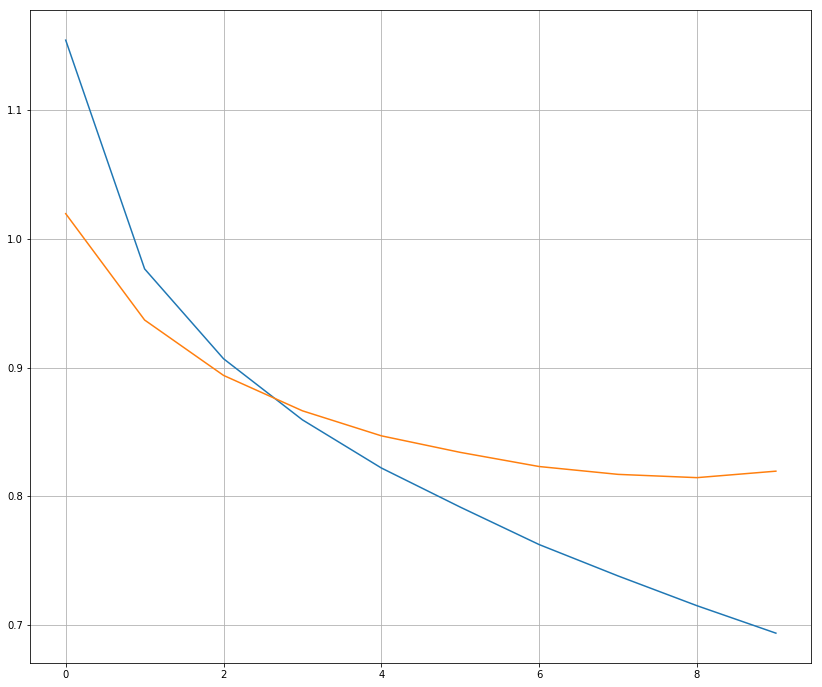

In [179]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), test_losses)
plt.grid()

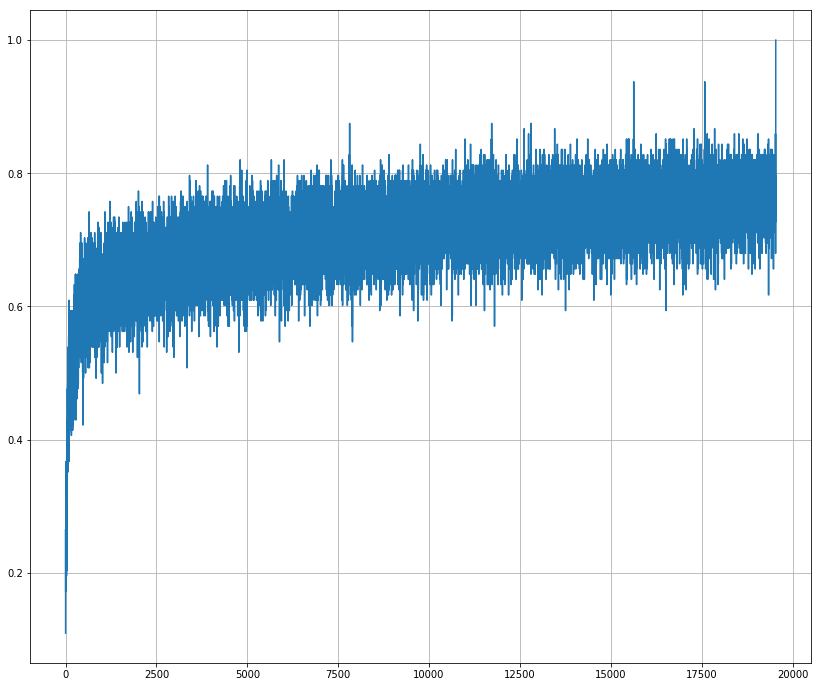

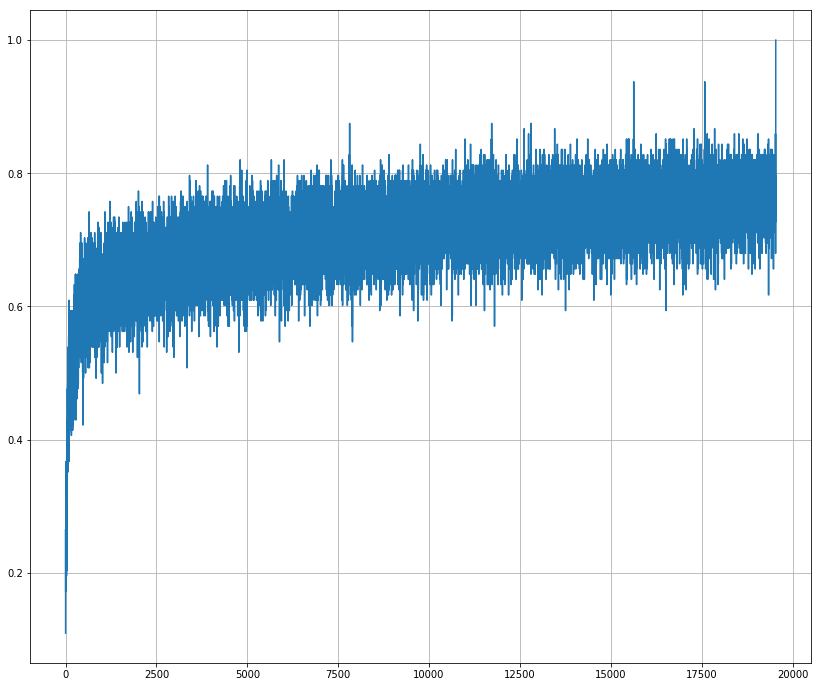

In [187]:
plt.figure(figsize=(14, 12))
plt.plot(metrics.train['f1'])
plt.grid()
plt.figure(figsize=(14, 12))
plt.plot(metrics.train['accuracy'])
plt.grid()

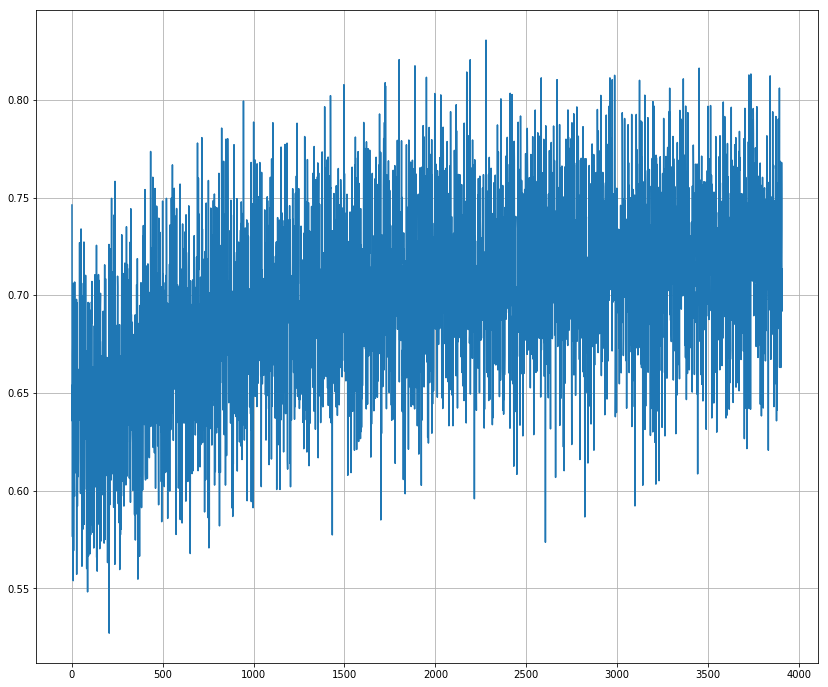

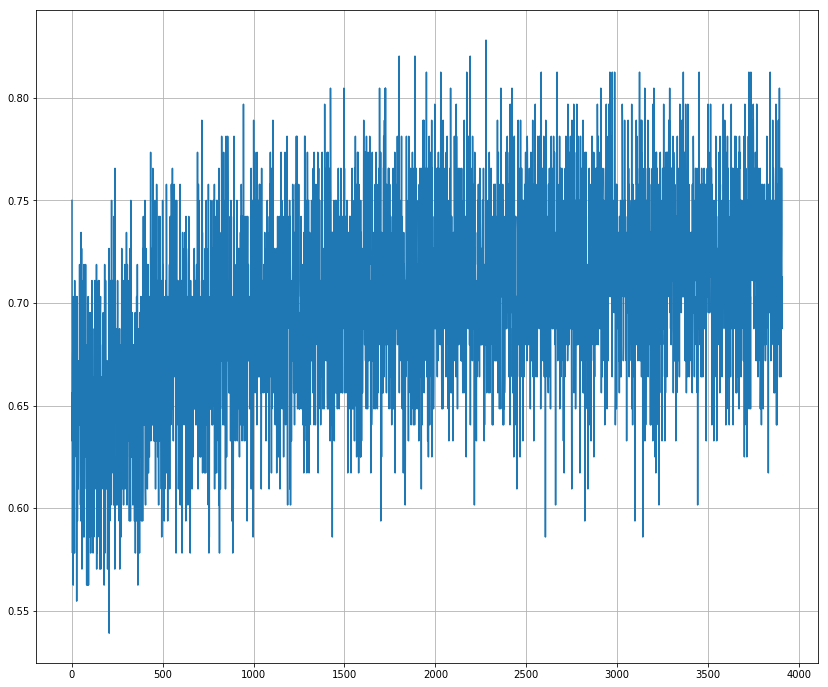

In [188]:
plt.figure(figsize=(14, 12))
plt.plot(metrics.test['f1'])
plt.grid()
plt.figure(figsize=(14, 12))
plt.plot(metrics.test['accuracy'])
plt.grid()